# Julia Set


In the notebook I present different way to accelerate python code. 
This is a modified version from [Loic Gouarin](https://github.com/gouarin/GTSage2014/)

The test case is the computation of the Julia set [wikipedia](https://en.wikipedia.org/wiki/Julia_set)

In [1]:
import os, sys

if sys.platform == 'darwin':
    os.environ['CC'] = 'gcc-10'
    os.environ['CXX'] = 'g++-10'

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%config InlineBackend.figure_format = 'retina'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.rcParams['figure.figsize'] = (6,6)

## Initialize Mesh

In [5]:
nx, ny = 512, 512 # mesh
lim, maxit = 400, 2000 # limits 
vmin, vmax = 0, 200 

x = np.linspace(-1.6, 1.6, nx)
y = np.linspace(-1.6, 1.6, ny)
c = -0.772691322542185 + 0.124281466072787j

## Pure Python

In [6]:
def juliaset_python(x, y, c, lim, maxit):
    """ 
    returns Julia set
    """
    julia = np.zeros((x.size, y.size))

    for i in range(x.size):
        for j in range(y.size):
            z = x[i] + 1j*y[j]
            ite = 0
            while abs(z) < lim and ite < maxit:
                z = z**2 + c
                ite += 1
            julia[j, i] = ite

    return julia

In [7]:
def plot_julia_set(julia):
    plt.figure(figsize=(6,6))
    plt.imshow(julia, cmap = cm.Greys, vmin=vmin, vmax=vmax)

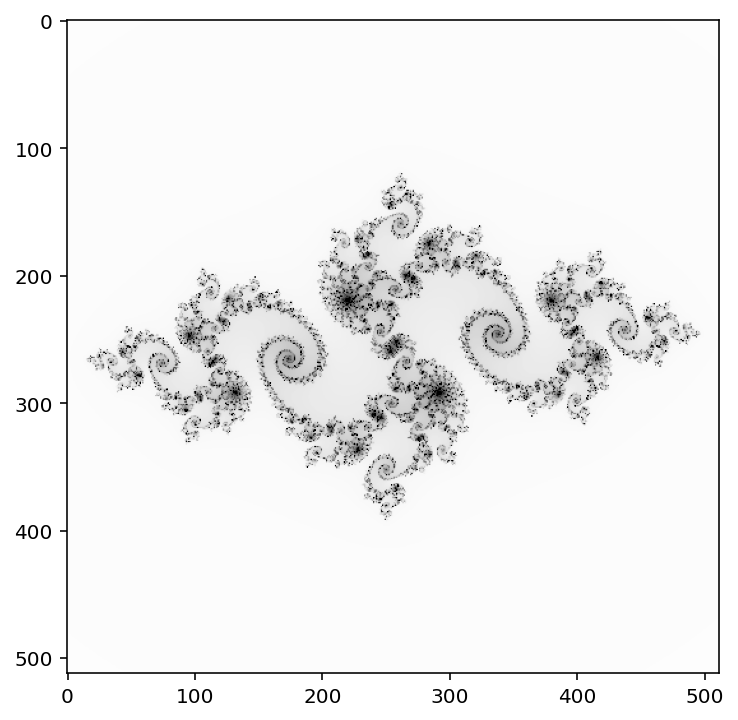

In [8]:
plot_julia_set(juliaset_python(x, y, c, lim, maxit))

## numba

[Numba](https://numba.pydata.org) will accelerate the pure python function just  with
the decorator `@jit`. Numba does everything for you.

In [9]:
from numba import jit

@jit(nopython=True, parallel=True)
def juliaset_numba(x, y, c, lim, maxit):
    julia = np.zeros((x.size, y.size))
    lim2 = lim*lim
    
    c = complex(c)  # needed for numba
    for j in range(y.size):
        for i in range(x.size):

            z = complex(x[i], y[j])
            ite = 0
            while (z.real*z.real + z.imag*z.imag) < lim2 and ite < maxit:
                z = z*z + c
                ite += 1
            julia[j, i] = ite

    return julia

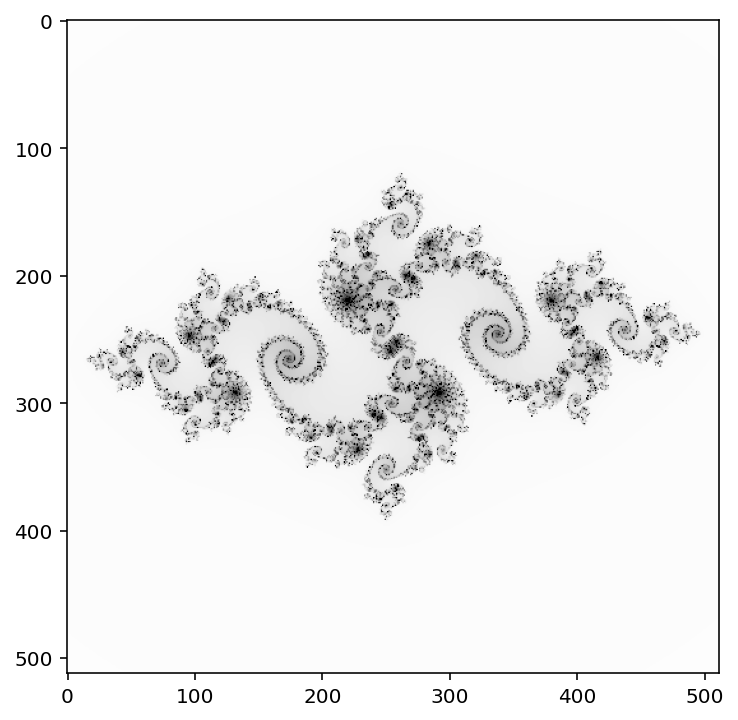

In [11]:
plot_julia_set(juliaset_numba(x, y, c, lim, maxit))

## PyJulia

[PyJulia](https://pyjulia.readthedocs.io/en/latest/#) is a python module to import
Julia function in your Python session. You can also run Julia code in a middle of
a Jupyter notebook with a Python kernel.

To use pyjulia you need to install [Julia](https://julialang.org/downloads/) and install [PyCall.jl](https://github.com/JuliaPy/PyCall.jl) and **REPL**

```
julia> using Pkg
julia> ENV["PYTHON"] = "/usr/local/bin/python3.7"
julia> Pkg.add("PyCall")
julia> Pkg.add("REPL")
julia> Pkg.build("PyCall")
```

print the value of `sys.executable` to know the python path. But the cell above could do the job.

In [12]:
import julia
julia.install()
from julia.api import Julia
jl = Julia(compiled_modules=False)

In [13]:
%%file julia_set.jl

function escapetime(z, c, lim, maxit)

    for n = 1:maxit
        if abs(z) > lim
            return n-1
        end
        z = z*z + c
    end
    return maxit
end

function juliaset_julia(x :: Vector{Float64}, y :: Vector{Float64}, 
                        c :: Complex, lim , maxit )
    
    nx = length(x)
    ny = length(y)
    julia = zeros(Float64, (nx, ny))
    Threads.@sync for i in eachindex(x)
        Threads.@spawn for j in eachindex(y)
            @inbounds z  = x[i] + 1im * y[j] 
            @inbounds julia[j, i] = escapetime(z, c, lim, maxit)
        end
    end
    return julia
end

Writing julia_set.jl


In [14]:
from julia import Main
juliaset_julia = Main.include("julia_set.jl")

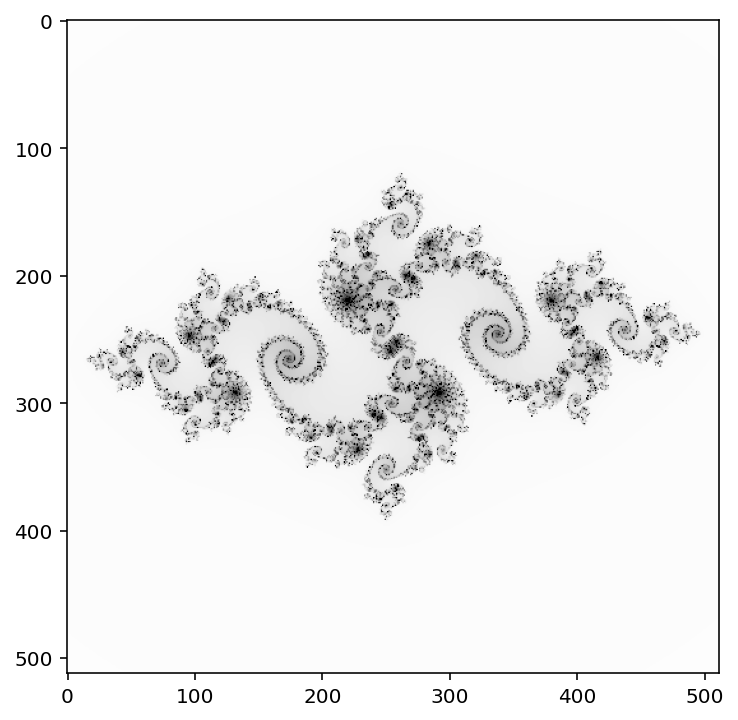

In [15]:
plot_julia_set(juliaset_julia(x, y, c, lim, maxit))

## Pythran

[Pythran](https://pythran.readthedocs.io/en/latest/) is a Python-to-C++ translator

Add a comment line before your python function and it runs much faster.

### Configuration

`~/.pythranrc` file on macos (gcc is installed with hombrew and pythran with pip)

```
[compiler]
include_dirs=/usr/local/opt/openblas/include
library_dirs=/usr/local/opt/openblas/lib
blas=openblas
CXX=g++-10
CC=gcc-10
```

In [16]:
%load_ext pythran.magic

In [17]:
%%pythran -fopenmp

import numpy as np

#pythran export juliaset_pythran(float64[], float64[],complex, int, int)
def juliaset_pythran(x, y, c, lim, maxit):
    """ 
    returns Julia set
    """
    juliap = np.zeros((x.size, y.size), dtype=np.int32)

    #omp parallel for private(z, ite)
    for j in range(y.size):
        for i in range(x.size):
            z = x[i] + 1j*y[j]
            ite = 0
            while abs(z) < lim and ite < maxit:
                z = z**2 + c
                ite += 1
            juliap[j, i] = ite

    return juliap

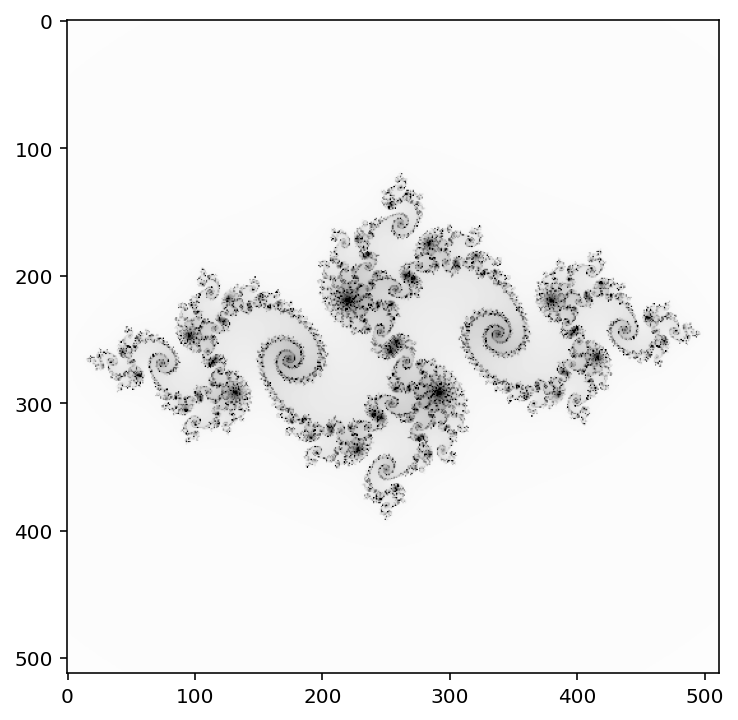

In [18]:
plot_julia_set(juliaset_pythran(x, y, c, lim, maxit))

## Fortran

You need [numpy](https://numpy.org) and [fortran-magic](https://github.com/mgaitan/fortran_magic)

In [19]:
%load_ext fortranmagic

On my mac i need to change compilers install with [homebrew](https://brew.sh)

Complex computation inside the loop are avoided on purpose. It takes time even with fortran.

In [20]:
%%fortran
subroutine juliaset_fortran(x, y, c, lim, maxit, julia)

    real(8),    intent(in)  :: x(:)
    real(8),    intent(in)  :: y(:)
    complex(8), intent(in)  :: c
    real(8),    intent(in)  :: lim
    integer,    intent(in)  :: maxit
    integer,    intent(out) :: julia(size(x),size(y))

    real(8)    :: zr, zi, limsq, cr, ci, tmp
    integer    :: ite, nx, ny

    nx = size(x)
    ny = size(y)
    limsq = lim * lim
    cr = real(c)
    ci = imag(c)

    do i = 1, nx
       do j = 1, ny   
            zr = x(i)
            zi = y(j)
            ite = 0
            do while (zr*zr+zi*zi < limsq .and. ite < maxit)
                tmp = zr*zr - zi*zi 
                zi = 2*zr*zi + ci
                zr = tmp + cr
                ite = ite + 1
            end do
            julia(j, i) = ite
        end do
    end do


end subroutine juliaset_fortran

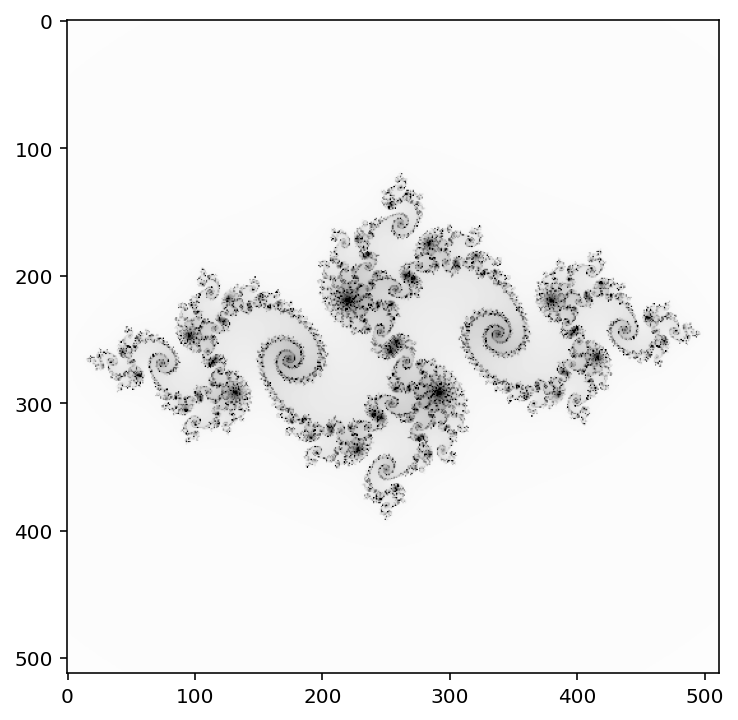

In [21]:
plot_julia_set(juliaset_fortran(x, y, c, lim, maxit))

## Fortran with OpenMP

On Linux you don't need to add `-L/usr/local/lib`

This is the same function from above with some openmp directives

In [22]:
%%fortran --f90flags "-fopenmp" --opt "-O3" --extra "-lgomp"
subroutine juliaset_fortran_omp(x, y, c, lim, maxit, julia)

    real(8),    intent(in)  :: x(:)
    real(8),    intent(in)  :: y(:)
    complex(8), intent(in)  :: c
    real(8),    intent(in)  :: lim
    integer,    intent(in)  :: maxit
    integer,    intent(out) :: julia(size(x),size(y))

    real(8)    :: zr, zi, limsq, cr, ci, tmp
    integer    :: ite, nx, ny

    nx = size(x)
    ny = size(y)
    limsq = lim * lim
    cr = real(c)
    ci = imag(c)

    !$OMP PARALLEL DEFAULT(NONE) &
    !$OMP FIRSTPRIVATE(nx,ny,x,y,c,limsq,maxit,cr,ci) &
    !$OMP PRIVATE(i,j,ite,zr,zi, tmp) &
    !$OMP SHARED(julia)
    !$OMP DO SCHEDULE(DYNAMIC)
    do i = 1, nx
       do j = 1, ny   
            zr = x(i)
            zi = y(j)
            ite = 0
            do while (zr*zr+zi*zi < limsq .and. ite < maxit)
                tmp = zr*zr - zi*zi 
                zi = 2*zr*zi + ci
                zr = tmp + cr
                ite = ite + 1
            end do
            julia(j, i) = ite
        end do
    end do  
    !$OMP END PARALLEL


end subroutine juliaset_fortran_omp

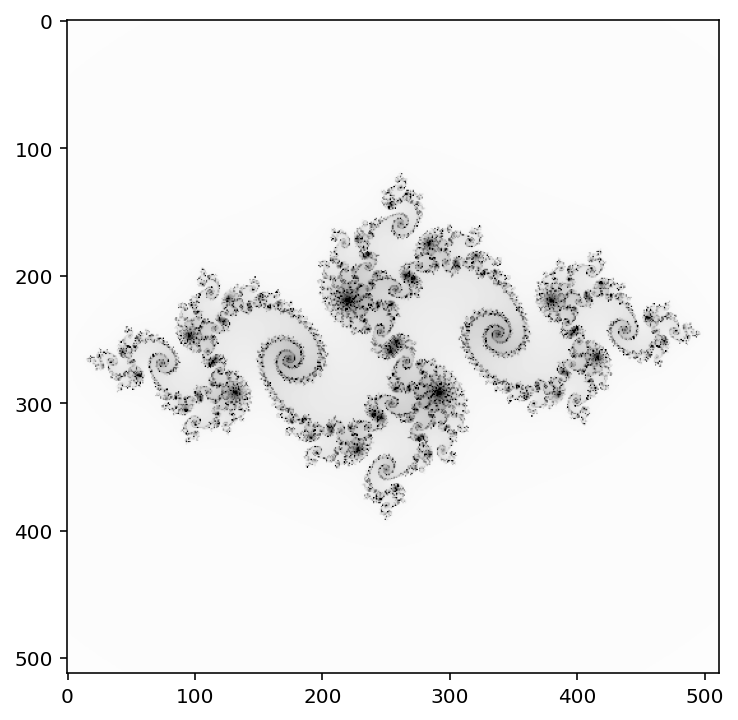

In [23]:
plot_julia_set(juliaset_fortran_omp(x, y, c, lim, maxit))

## Numpy

Vectorize version with numpy. You could get some overflow warnings

In [24]:
import itertools

def juliaset_numpy(x, y, c, lim, maxit):
    julia = np.zeros((x.size, y.size), dtype=np.int32)

    zx = x[np.newaxis, :]
    zy = y[:, np.newaxis]
    
    z = zx + zy*1j
    
    for ite in itertools.count():
        
        z = z**2 + c 
        mask = np.logical_not(julia) & (np.abs(z) >= lim)
        julia[mask] = ite
        if np.all(julia) or ite > maxit:
            return julia

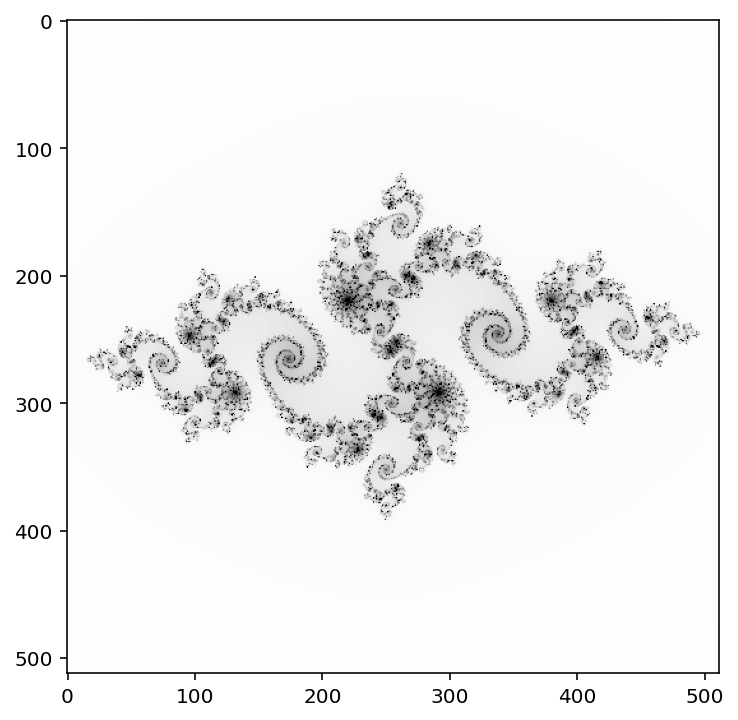

In [25]:
plot_julia_set(juliaset_numpy(x, y, c, lim, maxit))

## Cython

Install [Cython](https://cython.readthedocs.io)

Use `%%cython -a` to highlight the Python-C and C-Python conversions.

Cython is not Python and not C, it is another language :-)

In [26]:
%load_ext cython

In [27]:
%%cython
import numpy as np
import cython

@cython.boundscheck(False)
@cython.wraparound(False)
def juliaset_cython(double [:] x, double [:] y, double complex c, double lim, int maxit):
    cdef:
        int [:, ::1] julia = np.zeros((x.size, y.size), dtype = np.int32)
        double tmp, zr, zi, lim2 = lim*lim
        double cr = c.real, ci = c.imag
        int ite, i, j, nx=x.size, ny=y.size

    for i in range(nx):
        for j in range(ny):
            zr = x[i] 
            zi = y[j]
            ite = 0
            while (zr*zr + zi*zi) < lim2 and ite < maxit:
                zr, zi = zr*zr - zi*zi + cr, 2*zr*zi + ci
                ite += 1
            julia[j, i] = ite

    return julia

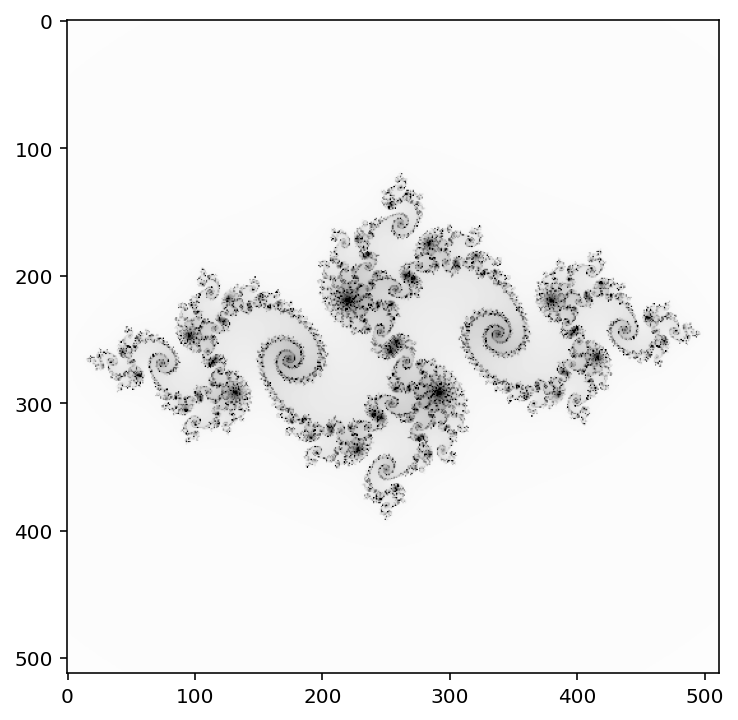

In [28]:
plot_julia_set(juliaset_cython(x, y, c, lim, maxit))

As f2py we can use openmp with the Cython `prange` function

In [31]:
%%cython -f -c-fopenmp --link-args=-fopenmp
import numpy as np
import cython
from cython.parallel import prange
from libc.stdlib cimport malloc, free 

@cython.boundscheck(False)
@cython.wraparound(False)
def juliaset_cython_omp(double [:] x, double [:] y, double complex c, double lim, int maxit):
    cdef:
        int [:, ::1] julia = np.zeros((x.size, y.size), dtype = np.int32)
        double tmp, zr, zi, lim2 = lim*lim
        double cr = c.real, ci = c.imag
        int  i, j, nx=x.size, ny=y.size
        int *ite

    for j in prange(ny, nogil=True, schedule='dynamic'):
        ite = <int *> malloc(sizeof(int))
        for i in range(nx):
            zr = x[i] 
            zi = y[j]
            ite[0] = 0
            while (zr*zr + zi*zi) < lim2 and ite[0] < maxit:
                zr, zi = zr*zr - zi*zi + cr, 2*zr*zi + ci
                ite[0] += 1
            julia[j, i] = ite[0]
        free(ite)
        
    return julia

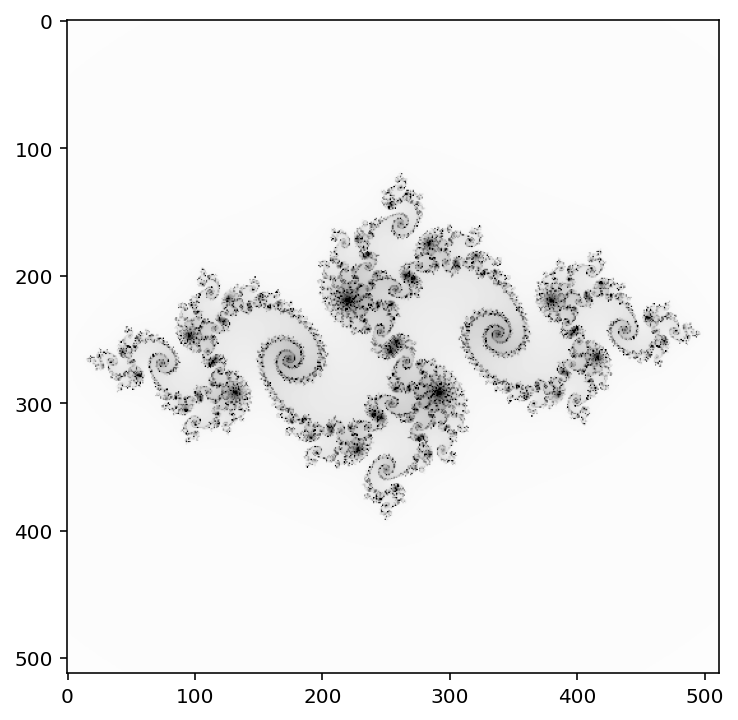

In [32]:
plot_julia_set(juliaset_cython_omp(x, y, c, lim, maxit))

### Set number of threads used for parallel functions

In [33]:
%env OMP_NUM_THREADS=4
%env JULIA_NUM_THREADS=4

env: OMP_NUM_THREADS=4
env: JULIA_NUM_THREADS=4


In [34]:
import pandas as pd
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
results = defaultdict(list)

nx, ny = 1024, 1024 # increase mesh size

x = np.linspace(-1.6, 1.6, nx)
y = np.linspace(-1.6, 1.6, ny)

functions = [juliaset_numpy,
             juliaset_fortran,
             juliaset_fortran_omp,
             juliaset_cython,
             juliaset_cython_omp,
             juliaset_numba,
             juliaset_pythran,
             juliaset_julia]

for f in tqdm(functions):

    _ = %timeit -oq -n 1 f(x, y, c, lim, maxit)
    results['etime'] += [_.best]
    
results = pd.DataFrame(results, index=list(map(lambda f:f.__name__[9:],functions)))
results["speed_up"] = [results.etime["numpy"]/t for t in results.etime]
results.sort_values(by="speed_up",axis=0)

,etime,speed_up
numpy,6.920963,1.000000
julia,0.083905,82.486083
numba,0.073950,93.589887
fortran,0.058941,117.422458
cython,0.056860,121.719685
pythran,0.043657,158.531005
fortran_omp,0.016614,416.571950
cython_omp,0.016206,427.060584
